In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler

In [3]:
# load data
data_path='./data/KPI_train.csv'
df=pd.read_csv(data_path)
# print(df.head)
print('Part of missing values for every column')
print(df.isnull().sum() / len(df))
kpi_ids=pd.unique(df['kpi_id'])
# print(kpi_ids)
# kpi_ids=['02e99bd4f6cfb33f' '9bd90500bfd11edb' 'da403e4e3f87c9e0'
#  'a5bf5d65261d859a' '18fbb1d5a5dc099d' '09513ae3e75778a3'
#  'c58bfcbacb2822d1' '1c35dbf57f55f5e4' '046ec29ddf80d62e'
#  '07927a9a18fa19ae' '54e8a140f6237526' 'b3b2e6d1a791d63a'
#  '8a20c229e9860d0c' '769894baefea4e9e' '76f4550c43334374'
#  'e0770391decc44ce' '8c892e5525f3e491' '40e25005ff8992bd'
#  'cff6d3c01e6a6bfa' '71595dd7171f4540' '7c189dd36f048a6c'
#  'a40b1df87e3f1c87' '8bef9af9a922e0b3' 'affb01ca2b4f0b45'
#  '9ee5879409dccef9' '88cf3a776ba00e7c']
groups=df.groupby('kpi_id')


Part of missing values for every column
start_time    0.0
end_time      0.0
value         0.0
label         0.0
kpi_id        0.0
dtype: float64


No handles with labels found to put in legend.


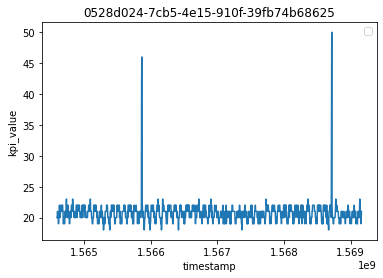

No handles with labels found to put in legend.


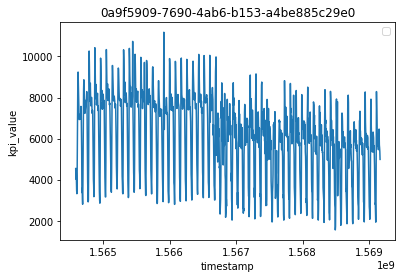

No handles with labels found to put in legend.


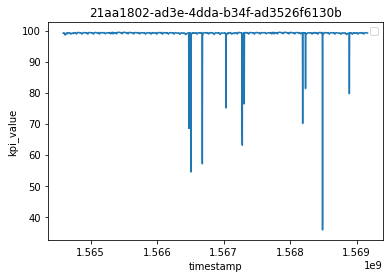

No handles with labels found to put in legend.


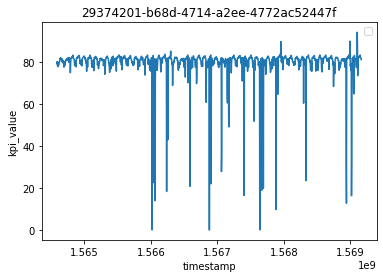

No handles with labels found to put in legend.


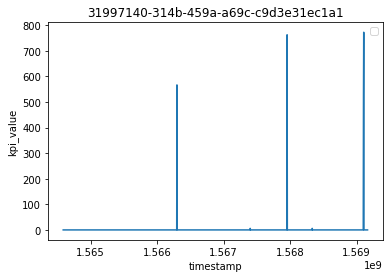

No handles with labels found to put in legend.


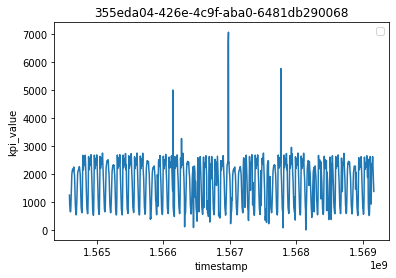

No handles with labels found to put in legend.


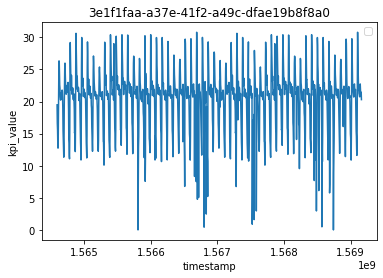

No handles with labels found to put in legend.


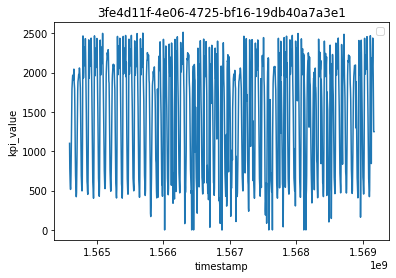

No handles with labels found to put in legend.


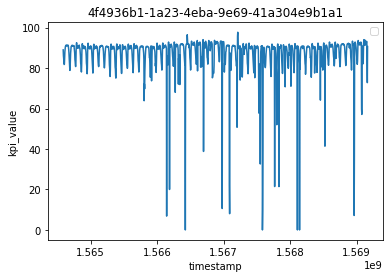

No handles with labels found to put in legend.


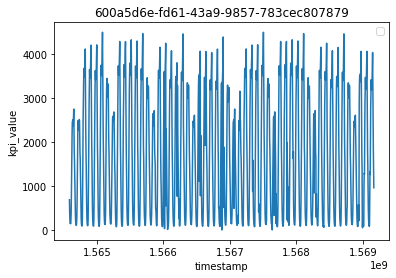

No handles with labels found to put in legend.


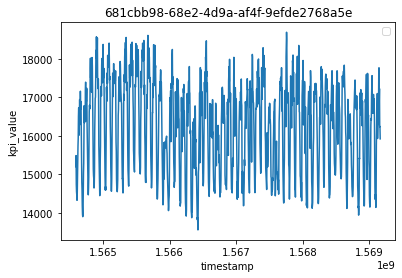

No handles with labels found to put in legend.


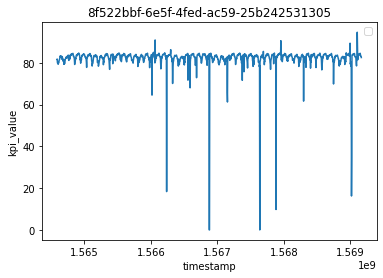

No handles with labels found to put in legend.


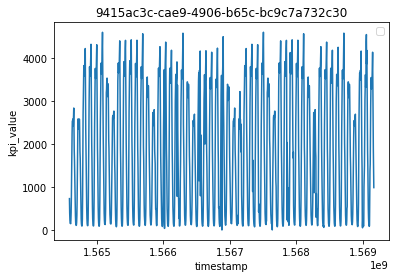

No handles with labels found to put in legend.


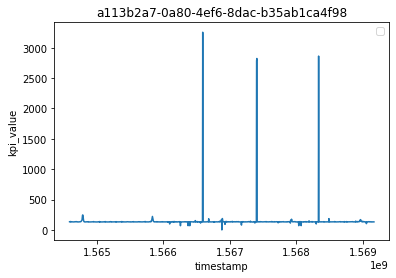

No handles with labels found to put in legend.


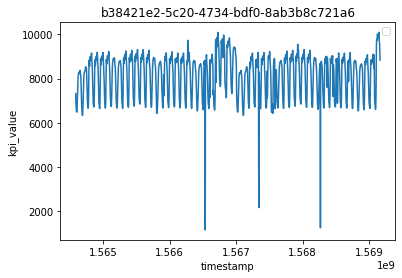

No handles with labels found to put in legend.


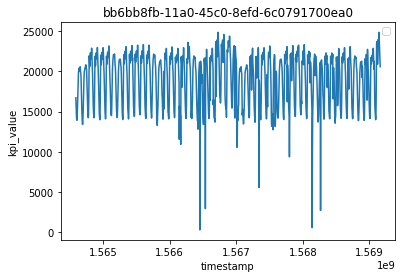

No handles with labels found to put in legend.


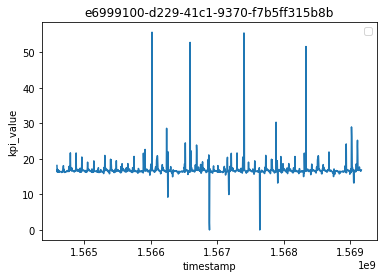

No handles with labels found to put in legend.


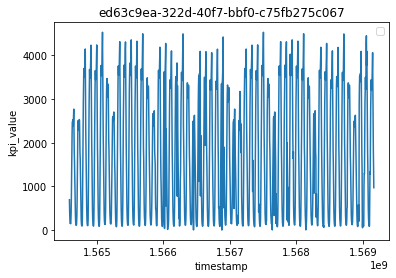

No handles with labels found to put in legend.


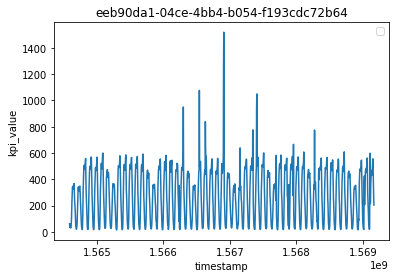

No handles with labels found to put in legend.


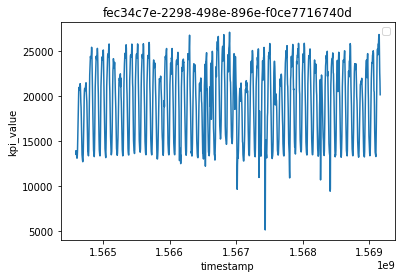

In [6]:
def draw_line(x,y,annotated_points=None,title=None,filename=None):
    # sub_axix = filter(lambda x:x%200 == 0, x_axix)
    plt.title(title)
    if annotated_points!=None:
        plt.plot(x, y, markevery=annotated_points,marker='o')
    else:
        plt.plot(x, y)
    plt.legend() # 显示图例
    plt.xlabel('timestamp')
    plt.ylabel('kpi_value')
    if filename!=None:
        if not os.path.exists('./figures'):
            os.makedirs('./figures')
        plt.savefig('./figures/{}'.format(filename))
    plt.show()
for k,k_df in groups:
    x,y=k_df['start_time'],k_df['value']
    # abnormal_points=k_df.where(k_df['label']==1).reset_index().index.tolist()
    # print(abnormal_points)
    draw_line(x,y,None,title=k,filename='%s.png'%k)

In [5]:
# 超参调优
sampler = TPESampler(seed=666)
def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    model = LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        learning_rate=learning_rate,
        feature_fraction=feature_fraction,
        random_state=666
)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(train_df[features], train_df[target])
    score = f1_score(test_df[target].values, model.predict(test_df[features]))
    return score



In [3]:
features = [
        'value','mean', 'var', 'mode','skew','std','max','min','median','cv','rolling_mean', 'rolling_var','rolling_skew','rolling_std','rolling_max','rolling_min','rolling_median','rolling_cv'
    ]
target = 'label'
params = {
'bagging_fraction': 0.5817242323514327,
'feature_fraction': 0.6884588361650144,
'learning_rate': 0.42887924851375825, 
'max_depth': 6,
'min_child_samples': 946, 
'min_data_in_leaf': 47, 
'n_estimators': 169,
'num_leaves': 29,
'random_state': 666
}

In [4]:
# train light-gbm models seperately for differnt kpi ids

def feature_engineering(data):
    mean=data['value'].mean()
    median=data['value'].median()
    var=data['value'].var() #方差
    mode=data['value'].mode()[0] #众数
    max_=data['value'].max()
    min_=data['value'].min()
    std=data['value'].std() #标准差
    skew=data['value'].skew() #偏度
    cv=std/mean #变异度
    rolling_mean=data['value'].rolling(window_size).mean()
    rolling_max=data['value'].rolling(window_size).max()
    rolling_min=data['value'].rolling(window_size).min()
    rolling_var=data['value'].rolling(window_size).var()
    rolling_skew=data['value'].rolling(window_size).skew()
    rolling_std=data['value'].rolling(window_size).std()
    rolling_median=data['value'].rolling(window_size).median()
    rolling_cv=rolling_std/rolling_mean
    data[['mean', 'var', 'mode','skew','std','max','min','median','cv']] = pd.DataFrame([[mean, var, mode,skew,std,max_,min_,median,cv]], index=data.index)
    data['rolling_mean'],data['rolling_var'],data['rolling_skew'],data['rolling_max'],data['rolling_min'],data['rolling_median'],data['rolling_std'],data['rolling_cv']=rolling_mean,rolling_var,rolling_skew,rolling_max,rolling_min,rolling_median,rolling_std,rolling_cv
    return data

# print(len(df))
# kpi_ids=pd.unique(df['KPI ID'])
# print(len(kpi_ids),kpi_ids)

window_size=5 #滑动窗口大小
cnt=0
scores=[]
for k,k_df in groups:
    # k_df.sample(frac=1.0)
    # k_df.reset_index()
    # train_rate=0.7
    # n_train=int(len(k_df)*train_rate)
    # train_df=k_df.iloc[0:n_train]
    # test_df=k_df.iloc[n_train:]
    k_df=feature_engineering(k_df)
    
    train_df, test_df = train_test_split(k_df, random_state=666, test_size=0.2)    
    # study = optuna.create_study(direction="maximize", sampler=sampler)
    # study.optimize(objective, n_trials=50)
    # params = study.best_params
    # params['random_state'] = 666
    model = LGBMClassifier(**params)
    model.fit(train_df[features], train_df[target])
    score = f1_score(test_df[target].values, model.predict(test_df[features]))
    print(k,'f1 score: ',score)
    scores.append(score)
print('average f1 score:', np.average(scores))

02e99bd4f6cfb33f f1 score:  0.6075798269173381
046ec29ddf80d62e f1 score:  0.888888888888889
07927a9a18fa19ae f1 score:  0.625
09513ae3e75778a3 f1 score:  0.034482758620689655
18fbb1d5a5dc099d f1 score:  0.8055908513341805
1c35dbf57f55f5e4 f1 score:  0.8764629388816646
40e25005ff8992bd f1 score:  0.0967741935483871
54e8a140f6237526 f1 score:  0.0
71595dd7171f4540 f1 score:  0.07246376811594203
769894baefea4e9e f1 score:  0.0
76f4550c43334374 f1 score:  0.888888888888889
7c189dd36f048a6c f1 score:  0.26519337016574585
88cf3a776ba00e7c f1 score:  0.5802707930367504
8a20c229e9860d0c f1 score:  0.0
8bef9af9a922e0b3 f1 score:  0.0
8c892e5525f3e491 f1 score:  0.7416462917685411
9bd90500bfd11edb f1 score:  0.048192771084337345
9ee5879409dccef9 f1 score:  0.5281285878300804
a40b1df87e3f1c87 f1 score:  0.0
a5bf5d65261d859a f1 score:  0.0
affb01ca2b4f0b45 f1 score:  0.06274509803921569
b3b2e6d1a791d63a f1 score:  0.0
c58bfcbacb2822d1 f1 score:  0.0
cff6d3c01e6a6bfa f1 score:  0.10071942446043165